## ***1. Data Preprocessing & Handling for MSAR*** 

This notebook focuses on analyzing stock price fluctuations and evaluating model fitting results using the Markov-Switching Autoregression (MSAR) framework. It processes time-series data of sectoral stocks and related index ETFs to examine regime dynamics, estimate transition probabilities, and assess the accuracy of the fitted models. The analysis aims to identify underlying market regimes (e.g., bull vs. bear) and evaluate how well the MSAR model captures changes in volatility, return behavior, and regime shifts over time. For more details about the project pipeline and workflow, please refer to the `README.md` file in the main branch.

### ***Prepare***

Load the necessary packages

In [1]:
# Necessary imports
import pandas as pd
from tqdm import tqdm
import torch
import os

### ***Step 1: Split Datasets***

The file **`symbols_valid_meta.csv`** currently contains a mixture of ETFs and individual stocks. Our first step is to separate this file into two corresponding CSV files: one for ETFs and one for stocks.

In [ ]:
file_path = r"data/symbols_valid_meta.csv" 
# The original stock dataset (~2.5 GB) is too large to be included in this repository.
# You can download it from Kaggle:
# 👉 [NASDAQ 100 Stock Price Data](https://www.kaggle.com/datasets/kalilurrahman/nasdaq100-stock-price-data)
# After downloading, place the data under the `data/` folder:



data = pd.read_csv(file_path)

etfs = data[data['ETF'] == 'Y']  
stocks = data[data['ETF'] == 'N']

# Save the separated data into new CSV files
etfs.to_csv(r"src/data_cleaned/etfs.csv", index=False)
stocks.to_csv(r"src/data_cleaned/stocks.csv", index=False)

# Check
print("ETFs and stocks have been separated and saved to 'etfs.csv' and 'stocks.csv'.")

ETFs and stocks have been separated and saved to 'etfs.csv' and 'stocks.csv'.


### ***Step 2: Industry Classifications***

There are many types of ETFs. However, in this discussion, we focus only on **Index ETFs**, whose prices and performance are primarily influenced by the movements of their constituent stocks.  

To analyze market regimes across industry sectors, we first need to identify which sector each stock and ETF belongs to. Since Index ETFs inherently consist of a mixture of stocks from different industries, it is difficult to assign them to a single sector. Therefore, we begin our analysis with **individual stocks**.  

Instead of classifying stocks based solely on keywords in their security names (which yielded poor accuracy — only about 400 out of 5,800 were correctly classified), we use official online resources such as ***[Nasdaq](https://www.nasdaq.com/)*** and ***[Yahoo! Finance](https://finance.yahoo.com/)***, which provide verified sector classifications. By scraping data from these websites, we add an additional column indicating the corresponding industry sector for each stock.  

The detailed implementation can be found in the script: `/src/utils/fill_industry.py`  

Run the `fill_industry.py` script to fill in industry sectors based on the classification tags provided by official online sources.


#### ***Handling Missing Industry Classifications***

After reviewing the stocks with unfilled industry sectors, we observed that it is often difficult to classify them based solely on their names or descriptions. This issue mainly arises because the stock symbols in our dataset differ from those used on the aforementioned reference websites.  

For example, **Almaden Minerals Ltd. Common Shares** appears as `AAU` in our dataset but is listed as `AAUAF` on ***[Nasdaq](https://www.nasdaq.com/market-activity/stocks/aauaf)***, resulting in missing (NA) values. 

However, this limitation is not a major concern. As an initial focus, we concentrate on the **technology** sector, where we already have sufficient data to analyze market fluctuations.  

To further improve coverage in the future, we suggest two potential enhancements:  
1. **Use additional data sources as backups.**  
   Incorporating ***[Yahoo! Finance](https://finance.yahoo.com/)*** has already reduced the number of NAs from 2,249 to 1,945.  
2. **Keyword-based classification for remaining NAs.**  
   Extract keywords from the `Security Name` field and map them to related industry categories.


In [3]:
file_path = r"src/data_cleaned/stock_with_industry_backup.csv"
data = pd.read_csv(file_path)

na_data = data[data["Industry"].isna() | (data["Industry"] == "N/A")]
na_data

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares,Industry,Source
12,Y,AAU,"Almaden Minerals, Ltd. Common Shares",A,,N,100.0,N,NaN,AAU,AAU,N,NaN,NaN
13,Y,AAWW,Atlas Air Worldwide Holdings - Common Stock,Q,Q,N,100.0,N,N,NaN,AAWW,N,NaN,NaN
14,Y,AAXN,"Axon Enterprise, Inc. - Common Stock",Q,Q,N,100.0,N,N,NaN,AAXN,N,NaN,NaN
16,Y,ABB,ABB Ltd Common Stock,N,,N,100.0,N,NaN,ABB,ABB,N,NaN,NaN
18,Y,ABC,AmerisourceBergen Corporation Common Stock,N,,N,100.0,N,NaN,ABC,ABC,N,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5871,Y,ZNH,China Southern Airlines Company Limited Common...,N,,N,100.0,N,NaN,ZNH,ZNH,N,NaN,NaN
5872,Y,ZOM,Zomedica Pharmaceuticals Corp. Common Shares,A,,N,100.0,N,NaN,ZOM,ZOM,N,NaN,NaN
5874,Y,ZSAN,Zosano Pharma Corporation - Common Stock,Q,S,N,100.0,N,N,NaN,ZSAN,N,NaN,NaN
5880,Y,ZVO,Zovio Inc. - Common Stock,Q,Q,N,100.0,N,N,NaN,ZVO,N,NaN,NaN


In [ ]:
"""
We grouped the stocks by their industry and saved each industry's data into separate CSV files.
"""

input_file = r"src/data_cleaned/stock_with_industry.csv"
output_dir = r"src/data_cleaned/stocks_categories"

data = pd.read_csv(input_file)
group = data.groupby("Industry")
for industry, group_data in tqdm(group, desc="Saving industry files"):
    safe_industry = industry.replace("/", "_").replace("\\", "_").replace(" ", "_").lower()
    output_file = f"{output_dir}/{safe_industry}.csv"
    group_data.to_csv(output_file, index=False)


Saving industry files: 100%|██████████| 11/11 [00:00<00:00, 447.98it/s]


### ***Step 3: Handle Data Type for Regression***

To fit the **MSAR** model, the stock data needs to be converted into a tensor of size **(k, n, m)**,  
where:
- **k** represents the number of industry sectors,  
- **n** represents the number of trading days, and  
- **m** represents the number of companies within each sector.  

This structured tensor format allows the MSAR model to capture both **cross-sectional** (between companies) and **temporal** (over time) dependencies when analyzing regime dynamics.

The script `src/utils/process_stock_data` is used to filter out available stocks within a defined time window. Currently, as an initial step, we use the **daily return** (calculated as `Close - Open`) to quantify the market situation and identify potential regime shifts.

In [ ]:
from src.utils.data_handler import process_stock_data

"""
The date here (from 2016-01-01 to 2016-02-01) is just for illustration purposes.
In the later analysis, we will use the date from 2016-02-01 to 2016-03-01 to generate the tensor.
"""

# file paths
category_file = r"src/data_cleaned/stocks_categories/technology.csv"
stocks_dir = r"data/stocks"

# time window
start_date = "2016-01-01"
end_date = "2016-02-01"

# process stock data
tensor, dates, retained_symbols, skipped_symbols = process_stock_data(category_file, stocks_dir, start_date, end_date)

# outputs
if tensor is not None:
    print(f"Tensor Shape: {tensor.shape}")
    print("Tensor Info:")
    print(tensor)
    print(f"Date Range: {dates[0]} to {dates[-1]}")
    print(f"Companies Symbol: {retained_symbols}")
else:
    print("Error in generating tensor.")

print(f"Skipped Symbol: {skipped_symbols}")

NaN counts per company:
BILL    19
dtype: int64
Dates with NaN values: [Timestamp('2016-01-04 00:00:00'), Timestamp('2016-01-05 00:00:00'), Timestamp('2016-01-06 00:00:00'), Timestamp('2016-01-07 00:00:00'), Timestamp('2016-01-08 00:00:00'), Timestamp('2016-01-11 00:00:00'), Timestamp('2016-01-12 00:00:00'), Timestamp('2016-01-13 00:00:00'), Timestamp('2016-01-14 00:00:00'), Timestamp('2016-01-15 00:00:00'), Timestamp('2016-01-19 00:00:00'), Timestamp('2016-01-20 00:00:00'), Timestamp('2016-01-21 00:00:00'), Timestamp('2016-01-22 00:00:00'), Timestamp('2016-01-25 00:00:00'), Timestamp('2016-01-26 00:00:00'), Timestamp('2016-01-28 00:00:00'), Timestamp('2016-01-29 00:00:00'), Timestamp('2016-02-01 00:00:00')]
Tensor Shape: torch.Size([20, 364])
Tensor Info:
tensor([[-0.6700,  2.7400, -0.5100,  ..., -0.0800, -0.2899, -1.1900],
        [-0.2200, -3.0400, -0.0700,  ..., -0.4900, -0.0527, -1.7200],
        [ 0.3500,  0.1400,  0.2500,  ..., -0.0700,  0.0527, -1.3400],
        ...,
        [-


The **`skipped symbols`** represent companies that did not exist during that period, while **`NaN`** values indicate companies that existed but have missing information on certain days within the interval.  

These missing values can help identify data gaps and guide how we handle incomplete time series in subsequent processing steps.

For the following specific case, the stock **`BILL`** has only two records within a year, which makes it meaningless to perform fitting on daily returns over the predefined period.  

If the **NaN** gaps are small (e.g., only one or two missing days within a consecutive range), we can apply **linear interpolation** using the returns from the day before and the day after to fill the missing values.


In [6]:
# BILL stock data filtering example
start = "2016-01-01"
end = "2017-01-01"

# Load and filter data
symbol = "BILL"
file_path = f"{stocks_dir}/{symbol}.csv"

if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
else:
    stock_data = pd.read_csv(file_path)
    if "Date" in stock_data.columns:
        stock_data["Date"] = pd.to_datetime(stock_data["Date"])
        filtered_data = stock_data[(stock_data["Date"] >= start) & (stock_data["Date"] <= end)]
        print(filtered_data if not filtered_data.empty else f"No data for {symbol} in the given range.")
    else:
        print(f"'Date' column missing in {file_path}.")

          Date    Open    High     Low   Close  Adj Close  Volume
137 2016-01-27  0.0438  0.0438  0.0438  0.0438     0.0438       0
138 2016-09-28  0.0490  0.0520  0.0490  0.0500     0.0500       0


#### ***Multi-Industry Tensor***

Apart from examining stocks within a single industry sector, we can also construct a **multi-industry tensor** by stacking data from multiple sectors. This allows us to explore potential interactions and influences across industries.  

A simple example is shown below. Additionally, all stock data processing steps described above can be applied similarly to `Index ETFs`.


In [7]:
from src.utils.data_handler import process_multi_industry

# file paths
categories_dir = r"src/data_cleaned/stocks_categories"
stocks_dir = r"data/stocks"

industries = ["energy", "healthcare", "technology", "real_estate"]  # example industries
start_date = "2000-08-08"
end_date = "2000-09-08"
n_companies = 5  # Number of companies per industry. The numbers may vary by industry. Here we use a simple fixed number for demonstration.

# Process multi-industry data
stacked_tensor, industry_names, industry_company_labels = process_multi_industry(
    industries, categories_dir, stocks_dir, start_date, end_date, n_companies
)

# Output results
if stacked_tensor is not None:
    print(f"Stacked tensor shape: {stacked_tensor.shape}")
else:
    print("No valid data for industries.")

for i, industry in enumerate(industry_names):
    print(f"Industry: {industry}")
    print(f"Companies: {industry_company_labels[i]}")

NaN counts per company:
PBR    2
dtype: int64
Dates with NaN values: [Timestamp('2000-08-08 00:00:00'), Timestamp('2000-08-09 00:00:00')]
NaN counts per company:
CGEN     3
INMD     1
TAK     22
dtype: int64
Dates with NaN values: [Timestamp('2000-08-08 00:00:00'), Timestamp('2000-08-09 00:00:00'), Timestamp('2000-08-10 00:00:00'), Timestamp('2000-08-11 00:00:00'), Timestamp('2000-08-14 00:00:00'), Timestamp('2000-08-15 00:00:00'), Timestamp('2000-08-16 00:00:00'), Timestamp('2000-08-17 00:00:00'), Timestamp('2000-08-18 00:00:00'), Timestamp('2000-08-21 00:00:00'), Timestamp('2000-08-22 00:00:00'), Timestamp('2000-08-23 00:00:00'), Timestamp('2000-08-24 00:00:00'), Timestamp('2000-08-25 00:00:00'), Timestamp('2000-08-29 00:00:00'), Timestamp('2000-08-30 00:00:00'), Timestamp('2000-08-31 00:00:00'), Timestamp('2000-09-01 00:00:00'), Timestamp('2000-09-05 00:00:00'), Timestamp('2000-09-06 00:00:00'), Timestamp('2000-09-07 00:00:00'), Timestamp('2000-09-08 00:00:00')]
NaN counts per compa

In [8]:
print("First industry (energy) - Complete matrix:")
print(stacked_tensor[:, :, 0])
print("\nSecond industry (healthcare) - Complete matrix:")  
print(stacked_tensor[:, :, 1])


First industry (energy) - Complete matrix:
tensor([[ 0.0541,  0.2706,  0.3247,  0.1623,  1.0823, -0.6494,  0.2164,  0.8117,
         -0.5141, -0.1623, -0.0135,  0.6899, -0.2976,  0.3517,  0.3111,  0.2570,
         -0.2706,  0.0541,  0.4600,  0.0271,  0.6223, -0.0541, -0.6223],
        [-0.6259,  0.4024, -0.0447,  0.6259,  1.0730, -0.8941,  0.5365,  2.4142,
         -0.9835,  1.6094,  0.0894,  0.4471, -0.4471, -0.8494,  0.2235,  3.1295,
         -1.3859, -0.4471,  0.8494,  0.0894, -1.2071,  1.3412, -0.9388],
        [-0.0848, -0.0446, -0.0312,  0.0603, -0.0379, -0.0402,  0.1161,  0.2188,
         -0.0982,  0.0179,  0.0759,  0.2031,  0.1027,  0.0223,  0.0580,  0.0938,
          0.0357,  0.1406,  0.1518, -0.0156, -0.2098,  0.2054, -0.1964],
        [ 0.0625, -0.2500,  0.2500,  0.0625, -0.2500, -0.1250, -0.8125,  0.1250,
          0.3125, -0.1250, -0.3750,  0.1875, -0.1250,  0.3125, -0.2500,  0.2500,
          0.1875,  0.3125, -0.1250,  0.1250, -0.3125,  0.3750,  0.3125]])

Second industry

## ***2. Markov-Switching Autoregression (MSAR)***

The **Markov-Switching Autoregression (MSAR)** model is a regime-switching time series framework that can automatically identify which market regime corresponds to **bull** or **bear** states. It allows model parameters to change according to an unobserved (hidden) regime variable over time.

At the core of the model is the following econometric equation:

$$
r_t = \mu_{s_t} + \varphi_{s_t} r_{t-1} + \sigma_{s_t} \varepsilon_t, \quad s_t \in \{0, 1\}
$$

where:
- $ s_t $ represents the **hidden regime**: Bull Market or Bear Market $ \in \{0, 1\}$
- Each regime has its own parameters:  
  - Mean $ \mu $  
  - Volatility $ \sigma^2 $  
  - Persistence $ \varphi $

The model estimates:
- **Transition probabilities:**
  $$
  P[i,j] = Pr(s_{t+1} = i \mid s_t = j)
  $$
- **One-step-ahead regime probabilities:**
  $$
  Pr(s_{t+1} = j \mid R_{1:t}), \quad \text{where } R_{1:t} = (r_1, r_2, ..., r_t)
  $$
- **Forecasted returns:**
  $$
  E[r_{t+1} \mid R_{1:t}]
  $$

To determine the **Bull** or **Bear** regime, we apply a comprehensive scoring system:

$$
score_j = w_1 \cdot \mu_j - w_2 \cdot \sigma_j + w_3 \cdot Pr(j \mid \text{data}) + w_4 \cdot Sharpe_j, \quad j = 1, ..., K
$$

where $ Sharpe_j = \frac{\mu_j}{\sigma_j} $ is the **Sharpe ratio**.  
The regime with the higher score is identified as **Bull**.

The MSAR model is implemented in the script: `/src/models/msar.py`. The results are analyzed and interpreted through the `analyze_regime()` function.

The `initial regime distribution` $ \pi_0 \equiv [Pr(s_0 = k)]_{K \times 1} $ represents the model’s prior belief about the probability of being in each market regime (e.g., Bull or Bear) **before** the time-series observations begin. This prior is obtained from the preceding **NLP analysis of CEO Linguistic Fingerprints**, and serves as the initial input to the MSAR model.


In [ ]:
"""
In the first part of **Linguistic Fingerprints of CEOs**, we currently focus on the following target companies.  
Therefore, we filter the tensor to retain only these companies as a starting point for our analysis.

Here, we used the date from 2016-02-01 to 2016-03-01 to generate the tensor.
"""
target_companies = ['AAPL', 'AMD', 'ASML', 'CSCO', 'INTC', 'MU', 'NVDA']

# Find indices of the target companies in retained_symbols
indices = [retained_symbols.index(company) for company in target_companies if company in retained_symbols]

# Filter the tensor and retained_symbols
filtered_tensor = tensor[:, indices]
filtered_symbols = [retained_symbols[i] for i in indices]

# Output the results
print(f"Filtered Tensor Shape: {filtered_tensor.shape}")
print(f"Filtered Companies: {filtered_symbols}")

Filtered Tensor Shape: torch.Size([21, 7])
Filtered Companies: ['AAPL', 'AMD', 'ASML', 'CSCO', 'INTC', 'MU', 'NVDA']


#### ***Initial State Handling in MSAR***

In the MSAR implementation, if no explicit initial state distribution $ \pi_0 $ is provided, the model assumes a **stationary distribution** as the starting point.  
This stationary distribution is determined by the estimated **state transition matrix** $ P $, and satisfies the equilibrium condition:

$$
P \pi = \pi
$$

That is, once the Markov chain reaches this distribution, the probabilities of being in each regime remain unchanged under further transitions.  

In practice, this means that without any external prior information (e.g., from CEO Linguistic Fingerprints), the model starts from the steady-state probabilities implied by $ P $.  
However, the **filtered probabilities** $ Pr(s_t | R_{1:t}) $ remain **time-varying**, as they are continuously updated based on the observed returns sequence $ R_{1:t} $.

In summary:
- When no prior is given $\rightarrow \pi_0 $ defaults to the stationary distribution of $ P $.
- When a prior (e.g., linguistic-based $ \pi_0 $) is available $\rightarrow$ it replaces the default and reflects external belief about the initial regime.


In [ ]:
# Reshape the tensor to (k, n, m)
k = 1
n, m = filtered_tensor.shape
reshaped_tensor = filtered_tensor.unsqueeze(0)  # Shape becomes (1, n, m)

# MSAR Model Application
import src.models.msar as msar
info = msar.msar(
        T=reshaped_tensor, 
        k_regimes=2,          
        order=1,              
        switching_ar=False,
        switching_variance=False,
        trend="c",
        # init_probs = [...]  # You can specify initial probabilities here if needed. Later, we will use the output from CEO Linguistic Fingerprints as prior information.
    )

In [11]:
msar.analyze_regime(info, c=0, i=0)

📊 Category 0, Stock 0
---------------------------------------------
μ by regime     : [ 0.01342173 -0.01738523]
σ² by regime    : [0.90412564 0.90412564]
φ by regime     : [-0.33867924 -0.33867924]

Current state probabilities p(s_t | Y₁:ₜ): [1.06148314e-20 1.00000000e+00]
Predicted next  probabilities p(sₜ₊₁ | Y₁:ₜ): [3.28714422e-32 1.00000000e+00]

→ Current regime  : Bull  (Regime 1)  (p=1.000)
→ Next predicted  : Bull  (Regime 1)  (p=1.000)

✅ Market likely remains in *Bull regime*.


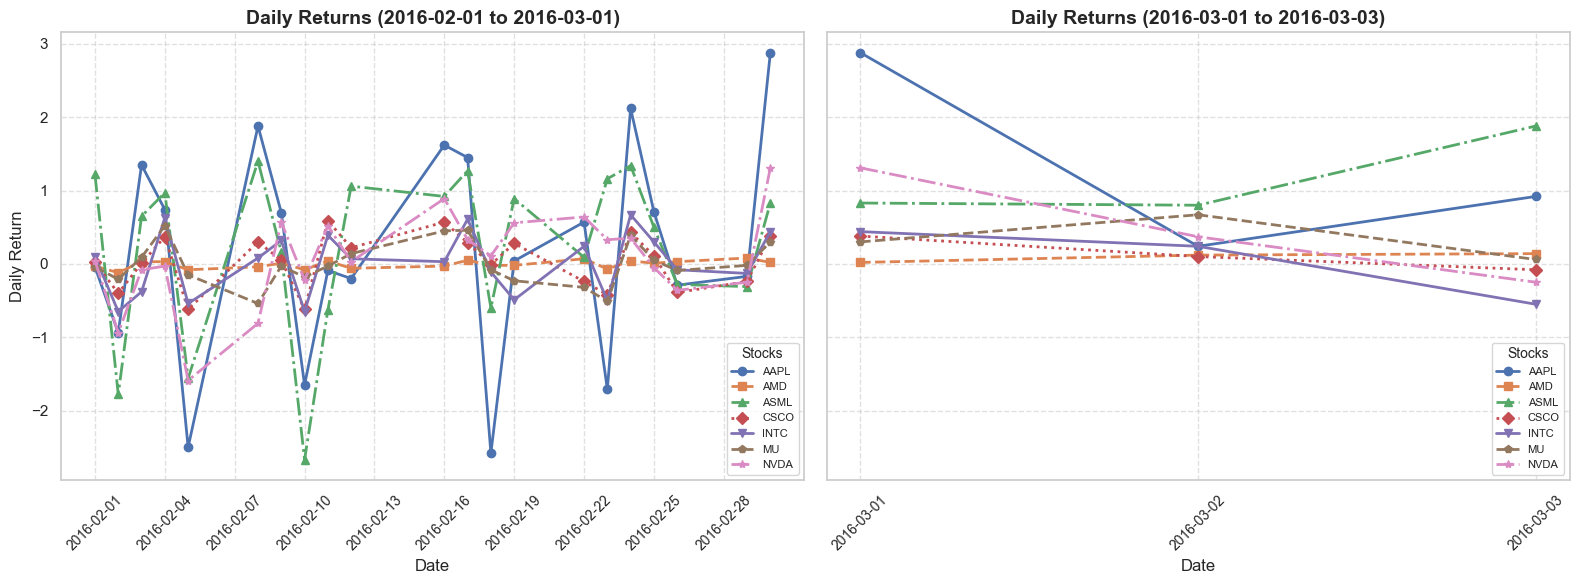

In [12]:
from src.utils.plot_stocks_return import plot_daily_returns_comparison

# Configurations
stocks_dir = r"data/stocks"
target_companies = ['AAPL', 'AMD', 'ASML', 'CSCO', 'INTC', 'MU', 'NVDA']
start_date1 = "2016-02-01"
end_date1 = "2016-03-01"
start_date2 = "2016-03-01"
end_date2 = "2016-03-03"

# Plot daily returns comparison
plot_daily_returns_comparison(stocks_dir, target_companies, start_date1, end_date1, start_date2, end_date2)

### ***Regime Interpretation and Validation***

The MSAR model output indicates that the **current market regime** (as of *2016-03-01*) is **Bull (Regime 1)** with a posterior probability of `p = 1.000`, and the **next predicted regime** (*2016-03-02*) is also Bull (`p = 1.000`). This implies that, based on the historical return dynamics between *2016-02-01* and *2016-03-01*, the model identifies the market as being in a stable upward-trending state with an extremely high confidence level.

To empirically validate this prediction, we compare the **daily returns** of the selected technology stocks (AAPL, AMD, ASML, CSCO, INTC, MU, NVDA) during the training window (*2016-02-01 to 2016-03-01*) and the subsequent date (*2016-03-02*).

- The left panel shows the **historical daily returns** used for training the MSAR model. On the current day (*2016-03-01*), the average market return remains positive, which is **consistent** with the Bull regime characterized by a positive mean return (`μ ≈ 0.0134`).

- The right panel illustrates the **realized returns** in the next day (*2016-03-02*). Although short-term fluctuations are present (e.g., a temporary drop in AAPL), most returns stay near or above zero, aligning with the model’s **Bull-to-Bull** prediction.

Overall, the market behavior after *2016-03-01* remains broadly consistent with the MSAR forecast. The persistence of positive or mildly fluctuating returns supports the conclusion that the market likely remains in a **Bull regime**, with no immediate signs of regime transition.

## ***3. Possible Improvement – Speech-Informed Regime Priors***

One potential improvement is to connect the **linguistic signals from CEO speeches** with the MSAR model.  
The idea is to convert text-based features (such as optimism, uncertainty, or hedging) into a **probabilistic prior** about the current market regime.

By estimating a logistic model:

$$
p^{\text{speech}}_t = \Pr(s_t = \text{Bull} \mid X_t)
$$

where \( X_t \) are the extracted NLP features,  
we can obtain an initial regime belief:

$$
\pi_0 = [\, p^{\text{speech}}_t,\; 1 - p^{\text{speech}}_t \,]
$$

This prior can then be passed to the MSAR model as the parameter `init_probs`,  
allowing the regime-switching process to start from a **speech-informed** state rather than a neutral one.  

In other words, CEO language provides an **early indicator** of whether the market is likely entering a Bull or Bear phase.



We use CEO **speech and interview transcripts** from  
`ada-2025-project-alwaysdominatingacademics\data\2016_2020_speech.zip`  
to extract linguistic indicators that may influence market behavior.

The analysis is implemented in  
`ada-2025-project-alwaysdominatingacademics\src\models\NLP.py`,  
which performs **semantic analysis** using OpenAI’s embedding model.  
Because it relies on the **OpenAI API**, a valid API key (`OPENAI_API_KEY`) is required to run this script.

---



In [ ]:
from pathlib import Path
from src.models.NLP_model import SpeechEmbeddingAnalyzer

analyzer = SpeechEmbeddingAnalyzer(topic_topk=5)
in_dir = r"ada-2025-project-alwaysdominatingacademics\data\2016_2020_speech.zip"
#Unzip the dir
df = analyzer.transform_folder(in_dir)
out = Path(in_dir).with_name("transcripts_2016_2020_analysis.xlsx")
df.to_excel(out, index=False)


#### **Pipeline Overview**

1. **Preprocessing & Chunking**  
   Each transcript is normalized and divided into chunks of ≤ 4000 characters to stay within model limits while preserving sentence boundaries.

2. **Embedding Generation**  
   Each chunk is converted into a 1536-dimensional vector using OpenAI’s **`text-embedding-3-small`** model.  
   The vectors are **mean-pooled** to form a document-level representation:
   $$
   \mathbf{v}_{\text{doc}} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{v}_i
   $$

3. **Anchor-Based Semantic Comparison**  
   The document embedding is compared (via cosine similarity) to **anchor embeddings** that represent reference concepts such as:  
   - Positive / Negative sentiment  
   - High / Low uncertainty  
   - Emotions: joy, fear, anger, sadness, trust, surprise  
   - Linguistic fingerprints: optimism, hedging, self-reference, jargon, complexity  
   - Business topics: profitability, AI strategy, liquidity, etc.  

   Cosine similarities are scaled to [0, 1] and interpreted as **feature intensities**.

4. **Lexical Metrics (Explainable Features)**  
   Count-based metrics are added for hedging words (“maybe”, “could”), self-references (“we”, “our”), and financial jargon.  
   Text complexity is measured by the **Flesch–Kincaid grade**.

5. **Feature Aggregation & Output**  
   Each transcript produces a row of metrics:
   - `sentiment`, `sent_conf`  
   - `uncertainty`  
   - `emo_*` (six basic emotions)  
   - `fp_*` (fingerprint features such as optimism, hedging_rate, complexity)  
   - `topics` (Top-5 detected topics with normalized weights)  

   The analysis results are exported to an Excel file:



In [ ]:
path = r"ada-2025-project-alwaysdominatingacademics\src\data_cleaned\processed_NLP\transcripts_2016_analysis_scaled.xlsx"
df = pd.read_excel(path)

# show the processed dataset
print("Number of rows:", len(df))
df.head()


Number of rows: 40


,file,sentiment,sent_conf,uncertainty,emo_joy,emo_anger,emo_fear,emo_sadness,emo_trust,emo_surprise,fp_optimism,fp_hedging_rate,fp_self_reference_rate,fp_jargon_density,fp_complexity_fk_grade,topics
0,2016-Apr-19-INTC.txt,Neutral,0.487319,0.235632,0.213166,0.775758,0.551198,0.785219,0.747989,0.194553,0.831901,0.297621,0.333684,0.590658,0.639240,revenue growth(0.09); ai strategy and product ...
1,2016-Apr-20-ASML.txt,Neutral,0.292572,0.074713,0.285266,0.303030,0.549020,0.923788,0.321716,0.793774,0.187785,0.463581,0.408824,0.250000,0.822789,customer demand and pipeline(0.09); revenue gr...
2,2016-Apr-21-AMD.txt,Neutral,0.378623,1.000000,0.319749,0.875758,0.298475,0.845266,0.252011,0.217899,0.646944,0.480361,0.572134,0.331971,0.684223,ai strategy and product roadmap(0.09); revenue...
3,2016-Apr-21-GOOGL.txt,Neutral,0.707428,0.224138,0.391850,0.433333,0.198257,0.600462,0.654155,0.867704,0.736374,0.369906,0.522635,0.239881,0.627404,revenue growth(0.09); ai strategy and product ...
4,2016-Apr-21-MSFT.txt,Neutral,0.807065,0.568966,0.887147,0.530303,0.531590,1.000000,0.815013,0.544747,0.700529,0.334870,0.528673,0.859464,0.845530,revenue growth(0.09); ai strategy and product ...


In [ ]:
# Load the normalized speech dataset
path = r"ada-2025-project-alwaysdominatingacademics\src\data_cleaned\processed_NLP\transcripts_2016_2020_analysis_scaled.xlsx"
df = pd.read_excel(path)
df.head()

✅ Normalized speech dataset loaded successfully!


,file,sentiment,sent_conf,uncertainty,emo_joy,emo_anger,emo_fear,emo_sadness,emo_trust,emo_surprise,fp_optimism,fp_hedging_rate,fp_self_reference_rate,fp_jargon_density,fp_complexity_fk_grade,topics
0,2016-Apr-19-INTC.txt,Neutral,0.487319,0.235632,0.213166,0.775758,0.551198,0.785219,0.747989,0.194553,0.831901,0.297621,0.333684,0.590658,0.639240,revenue growth(0.09); ai strategy and product ...
1,2016-Apr-20-ASML.txt,Neutral,0.292572,0.074713,0.285266,0.303030,0.549020,0.923788,0.321716,0.793774,0.187785,0.463581,0.408824,0.250000,0.822789,customer demand and pipeline(0.09); revenue gr...
2,2016-Apr-21-AMD.txt,Neutral,0.378623,1.000000,0.319749,0.875758,0.298475,0.845266,0.252011,0.217899,0.646944,0.480361,0.572134,0.331971,0.684223,ai strategy and product roadmap(0.09); revenue...
3,2016-Apr-21-GOOGL.txt,Neutral,0.707428,0.224138,0.391850,0.433333,0.198257,0.600462,0.654155,0.867704,0.736374,0.369906,0.522635,0.239881,0.627404,revenue growth(0.09); ai strategy and product ...
4,2016-Apr-21-MSFT.txt,Neutral,0.807065,0.568966,0.887147,0.530303,0.531590,1.000000,0.815013,0.544747,0.700529,0.334870,0.528673,0.859464,0.845530,revenue growth(0.09); ai strategy and product ...


### ***NASDAQ Index – Labeled Market Regimes***

This file  
`ada-2025-project-alwaysdominatingacademics\src\data_cleaned\processed_NLP\NASDAQ-Index_labeled.csv`  
contains the processed **NASDAQ daily index data** with additional **Bull/Bear regime labels** generated by `detect_bull_bear.py`.

Each row represents one trading day, including both **market metrics** and **detected regimes**:

| Column | Description |
|---------|-------------|
| `date` | Trading day (no weekends or holidays) |
| `close` | NASDAQ closing index value |
| `ret`, `logret` | Daily simple and log returns |
| `sma`, `vol` | Moving average (trend) and rolling volatility |
| `drawdown` | Percent drop from the previous maximum (peak) |
| `regime_A` | Trend-based Bull/Bear classification |
| `regime_B` | Trend + Volatility filter |
| `regime_C` | Drawdown-based rule |

---

#### **How Each Regime Type Is Defined**

- **A – Trend-only:**  
  Bull if the closing price is **above** the moving average (SMA) **and** the SMA is **increasing**.  
  Otherwise, it’s labeled as Bear.

- **B – Trend + Volatility filter:**  
  Same as A, but also requires volatility (`vol`) to be **below the 60th percentile** of recent volatility.  
  This identifies calmer, more stable Bull phases.

- **C – Drawdown-based:**  
  Bull if the index drawdown (distance from the last peak) is **better than –3%**,  
  and Bear if the market has dropped more than 3% from its previous high.

---


Early rows may have empty `sma` or `vol` values because rolling windows need a few prior days of data.  
This labeled dataset serves as the **market regime reference** for merging with the CEO **speech-based linguistic features** in later analysis.


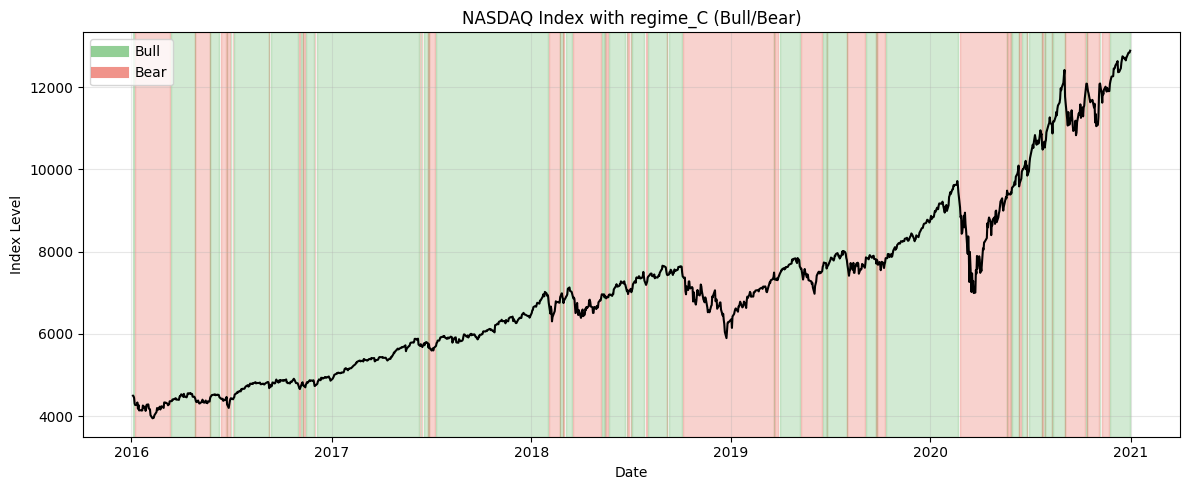

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Path and regime selection ---
path = r"E:\EPFLcourse\ADA\2025\ada-2025-project-alwaysdominatingacademics\src\data_cleaned\processed_NLP\NASDAQ-Index_labeled.csv"
regime_col = "regime_C"   # You can change this to "regime_B" or "regime_C"

# --- Load dataset ---
df = pd.read_csv(path, parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)

# --- Base plot ---
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df["date"], df["close"], lw=1.5, color="black", label="Index Close")
ax.grid(alpha=0.3)
ax.set_xlabel("Date")
ax.set_ylabel("Index Level")
ax.set_title(f"NASDAQ Index with {regime_col} (Bull/Bear)")

# --- Enhanced color shading by regime ---
dates = df["date"].to_numpy()
regimes = df[regime_col].to_numpy()

start = 0
for i in range(1, len(df) + 1):
    if i == len(df) or regimes[i] != regimes[start]:
        left = dates[start]
        right = dates[i-1]
        # Brighter green for Bull, deeper red for Bear
        color = "#4CAF50" if regimes[start] == "Bull" else "#E74C3C"
        ax.axvspan(left, right, color=color, alpha=0.25)
        start = i

# --- Legend (custom colored patches) ---
bull_patch = plt.Line2D([0],[0], color="#4CAF50", lw=8, alpha=0.6, label="Bull")
bear_patch = plt.Line2D([0],[0], color="#E74C3C", lw=8, alpha=0.6, label="Bear")
ax.legend(handles=[bull_patch, bear_patch], loc="upper left")

plt.tight_layout()
plt.show()


In [18]:
# --- Imports & paths ---
from pathlib import Path
import pandas as pd
import numpy as np

speech_path = Path(r"E:\EPFLcourse\ADA\2025\ada-2025-project-alwaysdominatingacademics\src\data_cleaned\processed_NLP\transcripts_2016_2020_analysis_scaled.xlsx")
market_path = Path(r"E:\EPFLcourse\ADA\2025\ada-2025-project-alwaysdominatingacademics\src\data_cleaned\processed_NLP\NASDAQ-Index_labeled.csv")

# --- Load ---
speech_df = pd.read_excel(speech_path)
market_df = pd.read_csv(market_path, parse_dates=["date"]).sort_values("date")

# --- Parse speech dates from filenames like '..._2016-Jan-20.txt' ---
speech_df["date"] = (
    speech_df["file"]
    .str.extract(r"(\d{4}-[A-Za-z]{3}-\d{2})")[0]
    .pipe(pd.to_datetime, format="%Y-%b-%d", errors="coerce")
)

# --- Map to NEXT trading day's regime_C (effect window = +1 day) ---
market_df["date_next"] = market_df["date"] - pd.Timedelta(days=1)
df = speech_df.merge(
    market_df[["date_next", "regime_C"]].rename(columns={"date_next": "date"}),
    on="date",
    how="left",
)

# --- Select usable features ---
features = [
    "sent_conf","uncertainty",
    "emo_joy","emo_anger","emo_fear","emo_sadness","emo_trust","emo_surprise",
    "fp_optimism","fp_hedging_rate",
]
df = df.dropna(subset=features + ["regime_C"]).copy()
df["regime_C"] = df["regime_C"].astype(str)

display(df[["file","date","regime_C"] + features].head())
print("\nFeature means by regime:")
display(df.groupby("regime_C")[features].mean())


,file,date,regime_C,sent_conf,uncertainty,emo_joy,emo_anger,emo_fear,emo_sadness,emo_trust,emo_surprise,fp_optimism,fp_hedging_rate
0,2016-Apr-19-INTC.txt,2016-04-19,Bull,0.487319,0.235632,0.213166,0.775758,0.551198,0.785219,0.747989,0.194553,0.831901,0.297621
1,2016-Apr-20-ASML.txt,2016-04-20,Bull,0.292572,0.074713,0.285266,0.303030,0.549020,0.923788,0.321716,0.793774,0.187785,0.463581
2,2016-Apr-21-AMD.txt,2016-04-21,Bull,0.378623,1.000000,0.319749,0.875758,0.298475,0.845266,0.252011,0.217899,0.646944,0.480361
3,2016-Apr-21-GOOGL.txt,2016-04-21,Bull,0.707428,0.224138,0.391850,0.433333,0.198257,0.600462,0.654155,0.867704,0.736374,0.369906
4,2016-Apr-21-MSFT.txt,2016-04-21,Bull,0.807065,0.568966,0.887147,0.530303,0.531590,1.000000,0.815013,0.544747,0.700529,0.334870



Feature means by regime:


,sent_conf,uncertainty,emo_joy,emo_anger,emo_fear,emo_sadness,emo_trust,emo_surprise,fp_optimism,fp_hedging_rate
regime_C,,,,,,,,,,
Bear,0.540502,0.458949,0.394537,0.490476,0.399626,0.644672,0.393719,0.514452,0.720338,0.431930
Bull,0.483138,0.399646,0.367856,0.522727,0.458354,0.746314,0.551969,0.527686,0.618141,0.459304


C:\Users\22729\AppData\Local\Temp\ipykernel_28404\369917888.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="regime_C", y=feat, order=order, palette=palette, width=0.6)


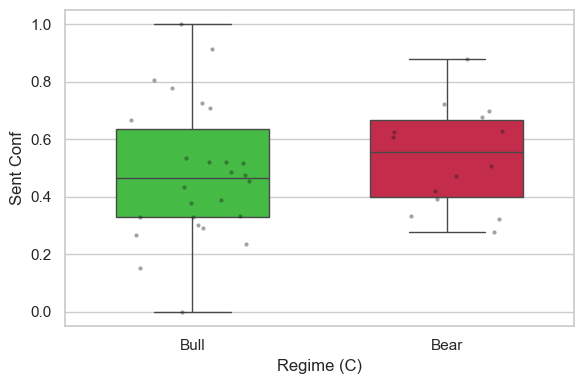

C:\Users\22729\AppData\Local\Temp\ipykernel_28404\369917888.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="regime_C", y=feat, order=order, palette=palette, width=0.6)


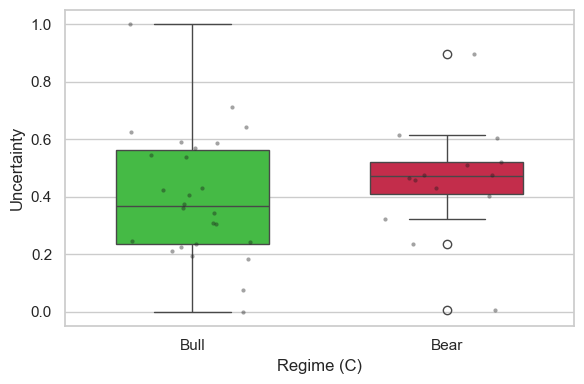

C:\Users\22729\AppData\Local\Temp\ipykernel_28404\369917888.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="regime_C", y=feat, order=order, palette=palette, width=0.6)


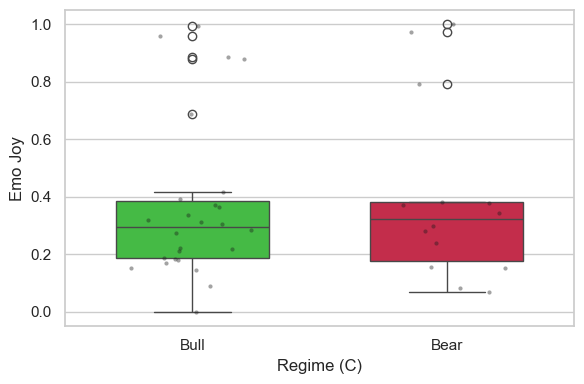

C:\Users\22729\AppData\Local\Temp\ipykernel_28404\369917888.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="regime_C", y=feat, order=order, palette=palette, width=0.6)


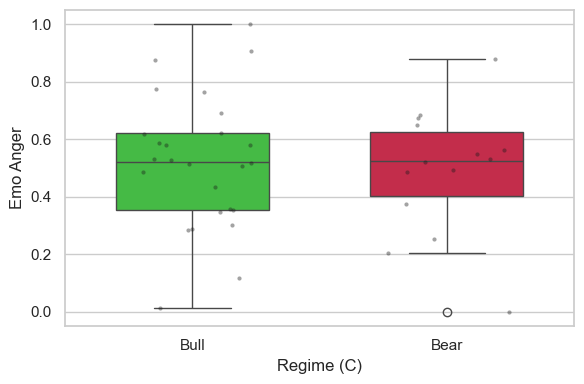

C:\Users\22729\AppData\Local\Temp\ipykernel_28404\369917888.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="regime_C", y=feat, order=order, palette=palette, width=0.6)


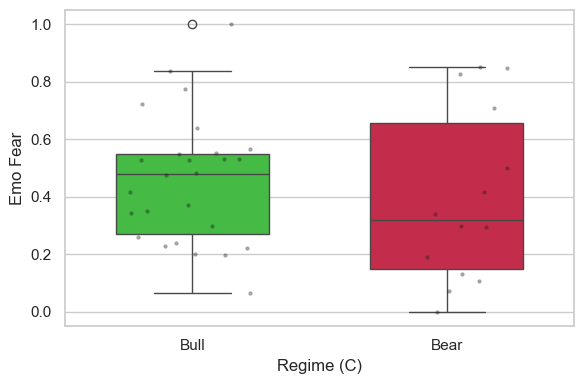

C:\Users\22729\AppData\Local\Temp\ipykernel_28404\369917888.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="regime_C", y=feat, order=order, palette=palette, width=0.6)


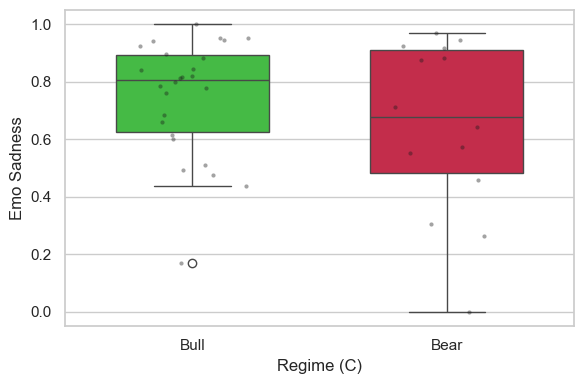

C:\Users\22729\AppData\Local\Temp\ipykernel_28404\369917888.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="regime_C", y=feat, order=order, palette=palette, width=0.6)


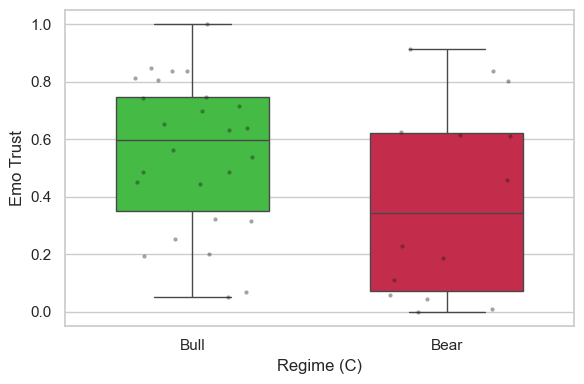

C:\Users\22729\AppData\Local\Temp\ipykernel_28404\369917888.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="regime_C", y=feat, order=order, palette=palette, width=0.6)


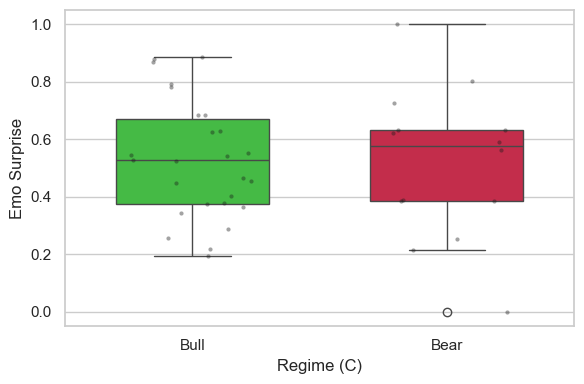

C:\Users\22729\AppData\Local\Temp\ipykernel_28404\369917888.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="regime_C", y=feat, order=order, palette=palette, width=0.6)


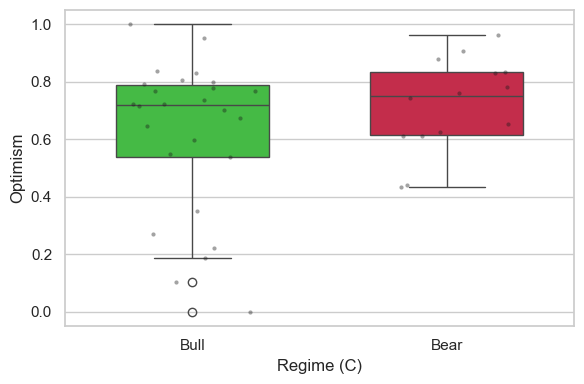

C:\Users\22729\AppData\Local\Temp\ipykernel_28404\369917888.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="regime_C", y=feat, order=order, palette=palette, width=0.6)


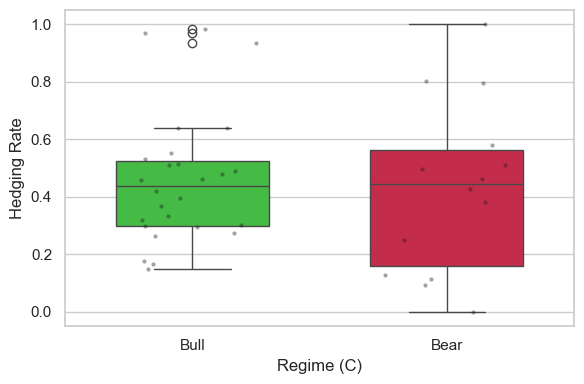

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
palette = {"Bull": "limegreen", "Bear": "crimson"}
order = [x for x in ["Bull", "Bear"] if x in df["regime_C"].unique()]

for feat in features:
    if df[feat].dtype.kind not in "fiu":
        continue

    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="regime_C", y=feat, order=order, palette=palette, width=0.6)
    sns.stripplot(data=df, x="regime_C", y=feat, order=order, color="k", alpha=0.4, size=3, jitter=0.25)

    plt.xlabel("Regime (C)")
    plt.ylabel(feat.replace("fp_","").replace("_"," ").title())
    plt.tight_layout()
    plt.show()


### Speech Style May Not Strongly Affect Market Regimes

The comparison between **CEO speech features** (optimism, hedging, emotions) and **market regimes** shows little difference because:

- **Market trends are mainly driven by macro factors**, such as economic policy, global events, or interest rates — not by speech tone.  
- **CEOs usually speak cautiously and consistently**, so their language does not fluctuate much with short-term market changes.  
- **Speech effects take time**, while the model tracks **daily** regime changes.  
- **Averaging across firms** can cancel out small linguistic variations.

Overall, using speech features alone to **predict market regime shifts** is likely **unreliable**, as language reflects sentiment but not the main drivers of market movements.
